In [12]:
import pandas as pd
import numpy as np
import re

results_log_path = r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\vision_log.txt'

# Load and parse log data
all_results = []
with open(results_log_path, 'r') as f:
    for line in f:
        match = re.search(r"Subject: (\w+),.*GT CPR cycles: ([\d.]+), Predicted CPR cycles: ([\d.]+)", line)
        if match:
            subject = match.group(1)
            gt_cycles = float(match.group(2))
            predicted_cycles = float(match.group(3))
            error = abs(gt_cycles - predicted_cycles)
            all_results.append([subject, gt_cycles, predicted_cycles, error])

# Create DataFrame
df = pd.DataFrame(all_results, columns=['Subject', 'GT CPR cycles', 'Predicted CPR cycles', 'Error'])

# Calculate averages per subject
summary_df = df.groupby('Subject').agg({
    'GT CPR cycles': 'mean',
    'Predicted CPR cycles': 'mean',
    'Error': 'mean'
}).reset_index()

# Rename columns for clarity
summary_df.columns = ['Subject', 'Average GT CPR cycles', 'Average Predicted CPR cycles', 'Average Error']

# Save to CSV
summary_df.to_csv(r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\subject_summary.csv', index=False)

print('Analysis complete. Results saved to subject_summary.csv.')


Analysis complete. Results saved to subject_summary.csv.


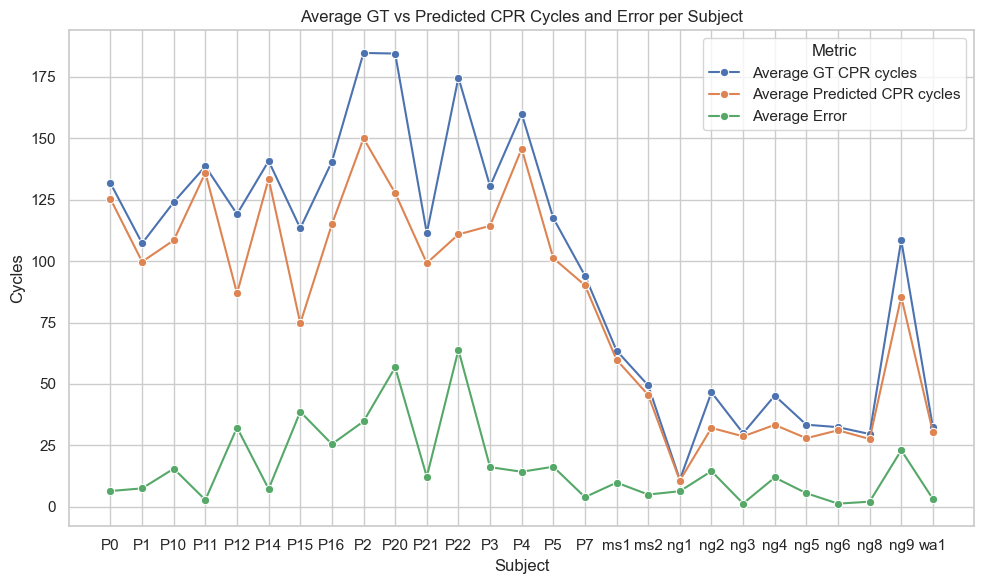

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the summary data
summary_df = pd.read_csv(r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\subject_summary.csv')

# Set up the plot style
sns.set(style="whitegrid")

# Melt the DataFrame to use in Seaborn
melted_df = summary_df.melt(id_vars='Subject', 
                            value_vars=['Average GT CPR cycles', 'Average Predicted CPR cycles', 'Average Error'],
                            var_name='Metric', value_name='Cycles')

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_df, x='Subject', y='Cycles', hue='Metric', marker="o")

# Add plot labels and title
plt.title('Average GT vs Predicted CPR Cycles and Error per Subject')
plt.xlabel('Subject')
plt.ylabel('Cycles')

# Display the plot
plt.tight_layout()
plt.show()


# Window wise detection

In [14]:
import pandas as pd
import numpy as np
import re

results_log_path = r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\window_vision_log.txt'

# Load and parse log data
all_results = []
with open(results_log_path, 'r') as f:
    for line in f:
        match = re.search(r"File: (\w+)_keypoints\.json, Window (\d+), Predicted CPR cycles: ([\d.]+), GT CPR cycles: ([\d.]+)", line)
        if match:
            subject = match.group(1).split('_')[0]
            window = int(match.group(2))
            predicted_cycles = float(match.group(3))
            gt_cycles = float(match.group(4))
            error = abs(gt_cycles - predicted_cycles)
            
            # Calculate CPR cycles per minute for GT, Predicted, and Error
            gt_cycles_per_min = (gt_cycles / 5) * 60
            predicted_cycles_per_min = (predicted_cycles / 5) * 60
            error_per_min = (error / 5) * 60
            
            all_results.append([subject, window, gt_cycles, predicted_cycles, error, gt_cycles_per_min, predicted_cycles_per_min, error_per_min])

# Create DataFrame
df = pd.DataFrame(all_results, columns=[
    'Subject', 'Window', 'GT CPR cycles', 'Predicted CPR cycles', 'Error', 
    'GT CPR cycles per min', 'Predicted CPR cycles per min', 'Error per min'
])

# Calculate averages per subject
summary_df = df.groupby('Subject').agg({
    'GT CPR cycles': 'mean',
    'Predicted CPR cycles': 'mean',
    'Error': 'mean',
    'GT CPR cycles per min': 'mean',
    'Predicted CPR cycles per min': 'mean',
    'Error per min': 'mean'
}).reset_index()

# Rename columns for clarity
summary_df.columns = [
    'Subject', 'Average GT CPR cycles', 'Average Predicted CPR cycles', 
    'Average Error', 'Average GT CPR cycles per min', 'Average Predicted CPR cycles per min', 
    'Average Error per min'
]

# Save to CSV
summary_df.to_csv(r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\window_subject_summary.csv', index=False)

print('Window-wise summary complete. Results saved to window_subject_summary.csv.')


Window-wise summary complete. Results saved to window_subject_summary.csv.


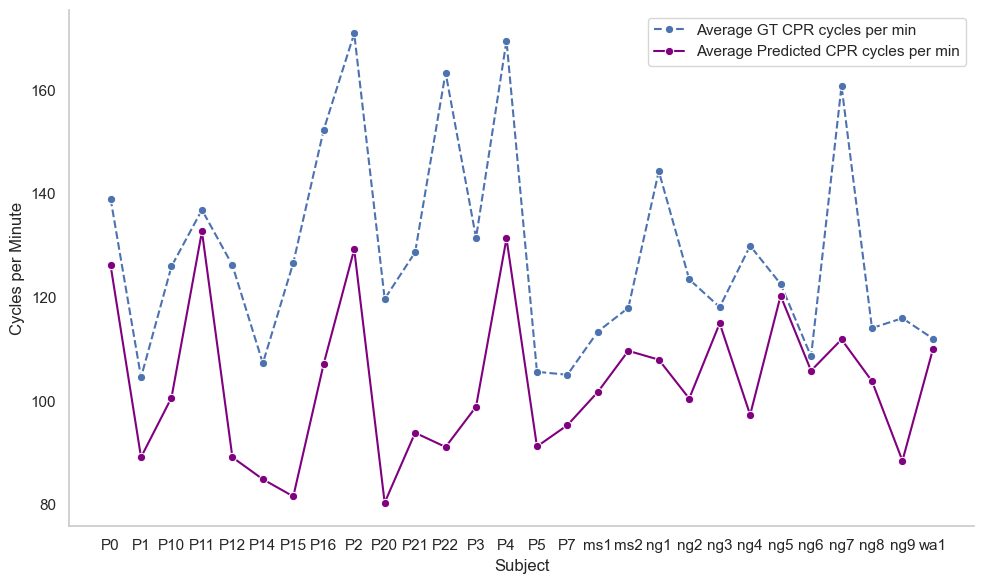

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the summary data
summary_df = pd.read_csv(r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\window_subject_summary.csv')

# Set up the plot style
sns.set(style="whitegrid")

# Melt the DataFrame to use in Seaborn
melted_df = summary_df.melt(id_vars='Subject', 
                            value_vars=['Average GT CPR cycles per min', 'Average Predicted CPR cycles per min'],
                            var_name='Metric', value_name='Cycles')

# Create the line plot with customized style
plt.figure(figsize=(10, 6))

# Plot GT rate with dashed line
sns.lineplot(
    data=melted_df[melted_df['Metric'] == 'Average GT CPR cycles per min'], 
    x='Subject', y='Cycles', label='Average GT CPR cycles per min', 
    linestyle='--',  marker="o"
)

# Plot Predicted rate with solid purple line
sns.lineplot(
    data=melted_df[melted_df['Metric'] == 'Average Predicted CPR cycles per min'], 
    x='Subject', y='Cycles', label='Average Predicted CPR cycles per min', 
    linestyle='-', color='purple', marker="o"
)

# Add plot labels and title
# plt.title('Average GT vs Predicted CPR Cycles per Minute per Subject')
plt.xlabel('Subject')
plt.ylabel('Cycles per Minute')

sns.despine()

# Disable grid
plt.grid(False)

# Display the plot
plt.tight_layout()
plt.show()


# Depth data

In [29]:
import pandas as pd
import re
import numpy as np

results_log_path = r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\outlier_depth_window_vision_log_pv_interpolated_final.txt'

# Load and parse log data
all_results = []
current_subject = current_window = None
predicted_cycles = gt_cycles = cycle_error = None
gt_cycles_per_min = predicted_cycles_per_min = cycle_error_per_min = None
predicted_depth = gt_depth = depth_error = None

with open(results_log_path, 'r') as f:
    for line in f:
        # Match CPR cycle data
        cycle_match = re.search(r"File: (\w+)_keypoints\.json, Window (\d+), Predicted CPR cycles: ([\d.]+), GT CPR cycles: ([\d.]+)", line)
        depth_match = re.search(r"File: (\w+)_keypoints\.json, Window (\d+), Predicted CPR depth: ([\d.]+|nan)mm, GT CPR depth: ([\d.]+|nan)mm", line)
        
        # Check for cycle data
        if cycle_match:
            # Save the cycle data
            current_subject = cycle_match.group(1).split('_')[0]
            current_window = int(cycle_match.group(2))
            predicted_cycles = float(cycle_match.group(3))
            gt_cycles = float(cycle_match.group(4))

            # Calculate CPR cycles per minute
            gt_cycles_per_min = (gt_cycles / 5) * 60
            predicted_cycles_per_min = (predicted_cycles / 5) * 60
            
        # Check for depth data
        if depth_match and int(depth_match.group(2)) == current_window:
            # Handle NaN values for depth by converting them to 0
            predicted_depth = float(depth_match.group(3)) if depth_match.group(3) != "nan" else 0.0
            gt_depth = float(depth_match.group(4)) if depth_match.group(4) != "nan" else 0.0
            
            # Append data for the current window only when both cycle and depth are parsed
            all_results.append([
                current_subject, current_window, gt_cycles, predicted_cycles,
                gt_cycles_per_min, predicted_cycles_per_min, 
                gt_depth, predicted_depth
            ])

# Create DataFrame
df = pd.DataFrame(all_results, columns=[
    'Subject', 'Window', 'GT CPR cycles', 'Predicted CPR cycles', 
    'GT CPR cycles per min', 'Predicted CPR cycles per min',
    'GT CPR depth', 'Predicted CPR depth'
])

# Replace any remaining NaN values in the DataFrame with 0
df = df.fillna(0)

# Calculate averages per subject for rates and depths
subject_avg = df.groupby('Subject').agg({
    'GT CPR cycles': 'mean',
    'Predicted CPR cycles': 'mean',
    'GT CPR cycles per min': 'mean',
    'Predicted CPR cycles per min': 'mean',
    'GT CPR depth': 'mean',
    'Predicted CPR depth': 'mean',
}).reset_index()

# Calculate errors based on the averages and add as new columns
subject_avg['Cycle Error'] = abs(subject_avg['Predicted CPR cycles'] - subject_avg['GT CPR cycles'])
subject_avg['Cycle Error per min'] = abs(subject_avg['Predicted CPR cycles per min'] - subject_avg['GT CPR cycles per min'])
subject_avg['Depth Error'] = abs(subject_avg['Predicted CPR depth'] - subject_avg['GT CPR depth'])

# Rename columns for clarity
subject_avg.columns = [
    'Subject', 'Average GT CPR cycles', 'Average Predicted CPR cycles', 
    'Average GT CPR cycles per min', 'Average Predicted CPR cycles per min', 
    'Average GT CPR depth', 'Average Predicted CPR depth', 
    'Cycle Error', 'Cycle Error per min', 'Depth Error'
]

# Save to CSV
subject_avg.to_csv(r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\outlier_depth_window_subject_summary.csv', index=False)

print('Subject-wise summary complete. Results saved to window_subject_summary.csv.')


Subject-wise summary complete. Results saved to window_subject_summary.csv.


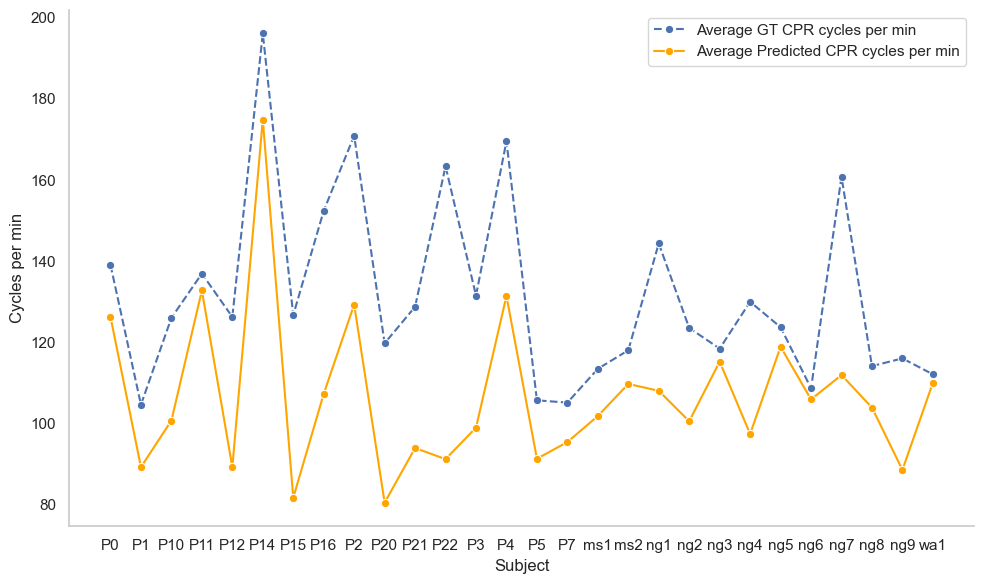

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the summary data
summary_df = pd.read_csv(r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\outlier_depth_window_subject_summary.csv')

# Set up the plot style
sns.set(style="whitegrid")

# Melt the DataFrame to use in Seaborn
melted_df = summary_df.melt(id_vars='Subject', 
                            value_vars=['Average GT CPR cycles per min', 'Average Predicted CPR cycles per min'],
                            var_name='Metric', value_name='Cycles')

# Create the line plot with customized style
plt.figure(figsize=(10, 6))

# Plot GT rate with dashed line
sns.lineplot(
    data=melted_df[melted_df['Metric'] == 'Average GT CPR cycles per min'], 
    x='Subject', y='Cycles', label='Average GT CPR cycles per min', 
    linestyle='--',  marker="o"
)

# Plot Predicted rate with solid orange line
sns.lineplot(
    data=melted_df[melted_df['Metric'] == 'Average Predicted CPR cycles per min'], 
    x='Subject', y='Cycles', label='Average Predicted CPR cycles per min', 
    linestyle='-', color='orange', marker="o"
)

# Add plot labels and title
# plt.title('Average GT vs Predicted CPR Cycles per Minute per Subject')
plt.xlabel('Subject')
plt.ylabel('Cycles per min')

sns.despine()

# Disable grid
plt.grid(False)

# Display the plot
plt.tight_layout()
plt.show()


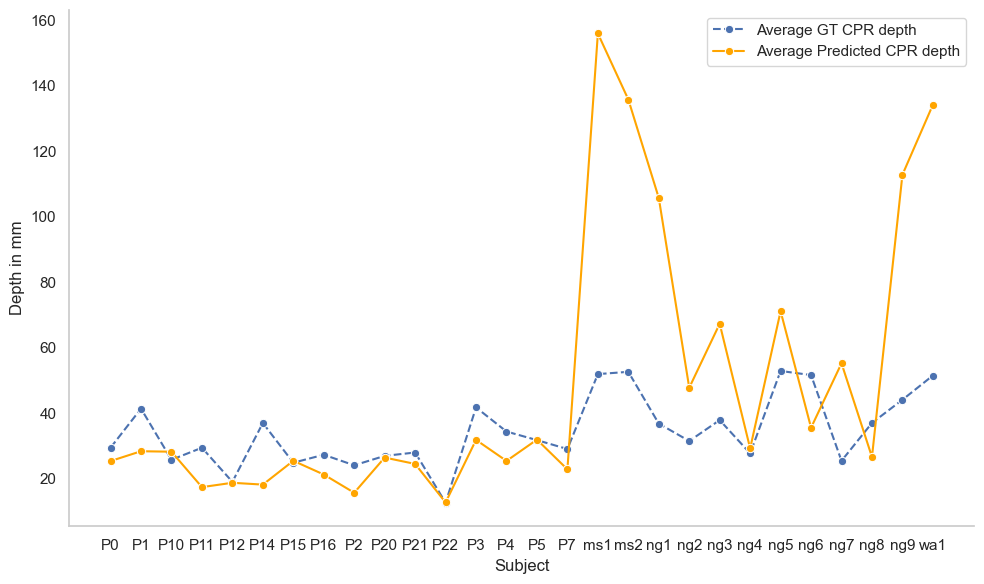

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the summary data
summary_df = pd.read_csv(r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\outlier_depth_window_subject_summary.csv')

# Set up the plot style
sns.set(style="whitegrid")

# Melt the DataFrame to use in Seaborn
melted_df = summary_df.melt(id_vars='Subject', 
                            value_vars=['Average GT CPR depth', 'Average Predicted CPR depth'],
                            var_name='Metric', value_name='Depth')

# Create the line plot with customized style
plt.figure(figsize=(10, 6))

# Plot GT rate with dashed line
sns.lineplot(
    data=melted_df[melted_df['Metric'] == 'Average GT CPR depth'], 
    x='Subject', y='Depth', label='Average GT CPR depth', 
    linestyle='--',  marker="o"
)

# Plot Predicted rate with solid orange line
sns.lineplot(
    data=melted_df[melted_df['Metric'] == 'Average Predicted CPR depth'], 
    x='Subject', y='Depth', label='Average Predicted CPR depth', 
    linestyle='-', color='orange', marker="o"
)

# Add plot labels and title
# plt.title('Average GT vs Predicted CPR Cycles per Minute per Subject')
plt.xlabel('Subject')
plt.ylabel('Depth in mm')

sns.despine()

# Disable grid
plt.grid(False)

# Display the plot
plt.tight_layout()
plt.show()


# Compare smartwatch cpr rate and vision rate

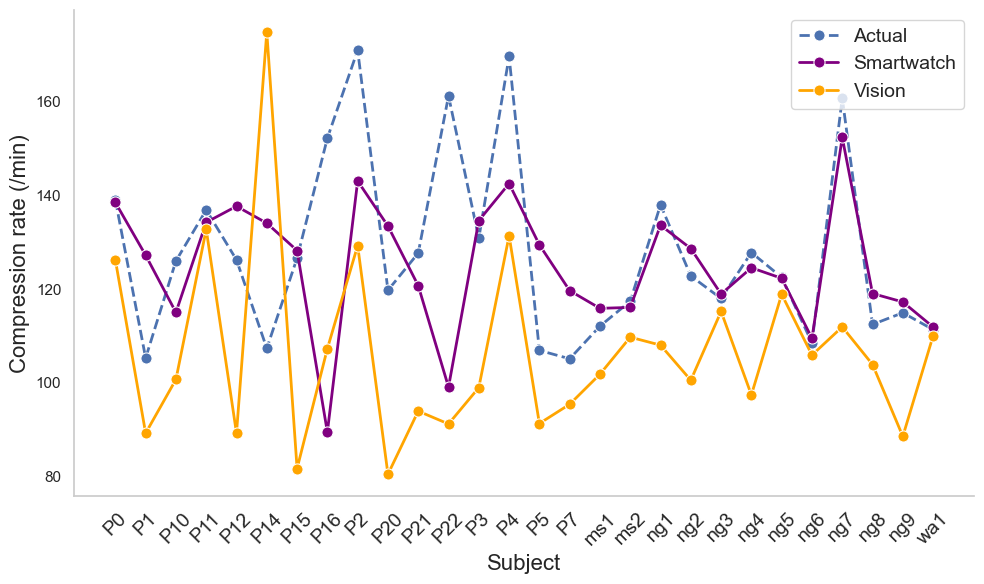

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load the smartwatch CSV data into a DataFrame
smartwatch_data = pd.read_csv("../smartwatch/averages_output.csv")
# Load the vision summary data
vision_data = pd.read_csv(r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\outlier_depth_window_subject_summary.csv')

# Merge the data on the participant/subject column
merged_data = pd.merge(
    smartwatch_data,
    vision_data.rename(columns={'Subject': 'participant'}), 
    on='participant', 
    how='inner'
)

# Create directory for saving plots
results_plots = './result_plots'
os.makedirs(results_plots, exist_ok=True)

# Set plot style
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot GT CPR Rate, Smartwatch Predicted CPR Rate, and Vision Predicted CPR Rate
sns.lineplot(x='participant', y='GT_CPR_rate_per_min', data=merged_data, marker='o', label='Actual', color='b', linestyle='--', linewidth=2, markersize=8)
sns.lineplot(x='participant', y='Keshara_Low_Pass_Pred_CPR_rate_per_min', data=merged_data, marker='o', label='Smartwatch', color='purple', linewidth=2, markersize=8)
sns.lineplot(x='participant', y='Average Predicted CPR cycles per min', data=merged_data, marker='o', label='Vision', color='orange', linewidth=2, markersize=8)

# Customize plot
plt.xlabel("Subject", fontsize=16)
plt.ylabel("Compression rate (/min)", fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.grid(False)
sns.despine()
plt.tight_layout()

# Save and show plot
plt.savefig(f'{results_plots}/CPR_Rate_Comparison_with_Vision.png')
plt.show()
